In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go
import random

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score




import wrangle
import seaborn as sns
import exploration



# Zillow Home Prediction Model



--- 

## Project Goal 

- The goal of this project is to create a reproducible  machine learning regression model to predict the ‘tax assed value’ of a single family home within three regions. 
- In order to achieve an accurate prediction, the project will identify key drivers of property values. This notebook serves as a way to understand why and how I made the prediction model.

---

## Project Description

- The residential real estate market accounts for $8.5 billion with a projected growth rate of 50% by the end of 2020's. However, the price of single family homes can vary drastically despite having the same size and features. Using the available Zillow data, this project will select key features such as bed/bath ratio and square footage try and accurately predict a homes value. 

---

### Key Questions

1. How does the house value relate the overall square foot? Is it better than just the home's square footage?

2. How is the house value reflected by the bed to bath ratio?

3. How does the house value reflect how many garages the house has?

4. How does having a pool affect house value?

5. To what extent does the age of the house affect house value? 

---

### Data Dictionary

Variable | Definiton | 
--- | --- | 
TaxAmount | The total property tax assessed for that year |
--- | --- | 
RegionCountyID | The county in which the property is located |
--- | --- | 
Fed_Code | Federal Information Processing Stardard code |
--- | --- | 
Bed_Bath_Ratio | The ratio of bedrooms to bathrooms the house has |
--- | --- | 
Home_Value | The target variable and how much the assesment value of the home  |
--- | --- | 
Sq_ft | The total sqaure footage of the house | 
--- | --- | 
Lot_Size | The size of the lot the house sits on |
--- | --- | 
Pool_Encoded | 1 - The property has a pool, 2 - The property does not have a pool |
--- | --- | 
House_Age | How old the house is in years |
--- | --- | 
Garages | The count of garage size in 'cars' |
--- | --- | 
Overall_Size | The overall property size ie: the lot square footage plus the house square footage |


## Data Acquisition
---
* Using mySQL, I brought in all the features I selected from the Zilloq dataset utilizing wrangle.py.
* The tables I joined and pulled from are: properties_2017, predicitions_2017, and propertylandusetype

In [2]:
# Assigning the dataframe to a variable and checking the results 
z_df = wrangle.wrangle_zillow()

z_df.head(0)

/Users/jarad/codeup_data_science/zillow_home_prediction_project/wrangle.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fed_code"] = df["fips"].astype(int)
/Users/jarad/codeup_data_science/zillow_home_prediction_project/wrangle.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year_built"] = df["yearbuilt"].astype(int)
/Users/jarad/codeup_data_science/zillow_home_prediction_project/wrangle.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,regionidcounty,fed_code,home_value,sq_ft,lot_size,pools,garages,pool_encoded,bed_bath_ratio,overall_size,house_age


### _Data Acquisition takeaways_
---
* There are roughly 50,000 observations with every line representing a single family home transaction in 2017
* There are 15 features which describe an attribute about the house.


## __Data Cleaning and Prep__
---
* To handle nulls, I compared the number of nulls for each category against the length of the entire data from. I decided to drop the nulls because they accounted for less than 1% of the total dataset.
* From wrangle.py I used the function to split the data into train, test, validate
* I changed the column names in order to be understood more simply and easier to read
* I transformed the nulls to zeros for the pool and garage columns. They are very large features and have a high likelihood of being added if presented. Since there was no zeros and only nulls, I interpreted the nulls to be zeros. 
* I dropped duplicate features that were used for encoded and features used to create new feature ratios
* Wrangle.py also houses my scaling functions I use to scale relevant data

---

In [3]:
# importing the function to split my data to ensure no leakage
z_train, z_validate, z_test = wrangle.split_zillow(z_df)

z_train.shape, z_validate.shape, z_test.shape

((31023, 11), (7756, 11), (9695, 11))


## Data Exploration
---
* ___Please see the explore notebook to asses all the visuals and analysis___

* To show how the feature correlates to the target variable, I plotted all features against the target variable
---
## Questions and Answers
* ### Question 1) How does the house value relate the overall square foot? Is it better than the home's square foot?


<AxesSubplot:xlabel='sq_ft', ylabel='home_value'>

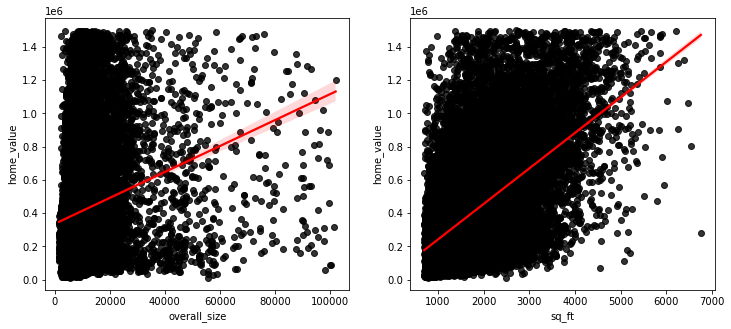

In [4]:
# Creating a subplot to compare two features to see which one I rather use
plt.figure(figsize=(12,5))
plt.subplot(1, 2,1)
sns.regplot(x="overall_size", y="home_value", data=z_train, scatter_kws={"color": "black"}, line_kws={"color": "red"})

plt.subplot(1, 2,2)
sns.regplot(x="sq_ft", y="home_value", data=z_train, scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [5]:
# Importing spearman test to test for statistical significance
exploration.spearman_test('overall_size', z_train)

We reject the null hypothesis and this variable is statistically significant


_Overall size does have a positive correlation with home value, however, I wanted to see how it compared to the house's square footage. The overall size has more variance as we see with the line of best fit having a larger band. Although overall size is statistically significant, it does not have a better correlation than square feet. So I will use square feet in the model instead of overall size._ 

# Questions 2-5: 

2. How does the house value reflected by the bed to bath ratio? 

3. How does the house value reflect how many garages the house has?

4. How does having a pool affect house value?

5. to what extent does the age of the house affect house value? 

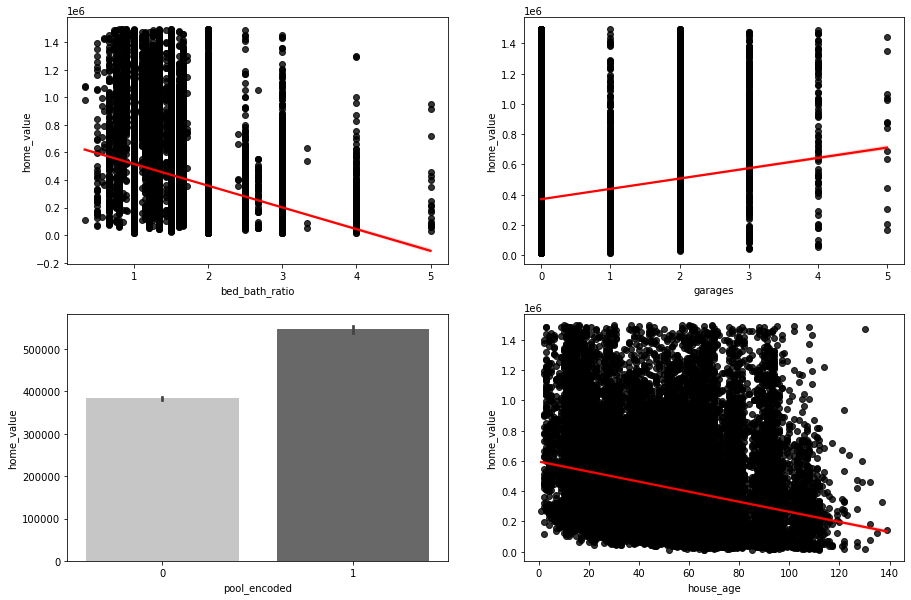

In [6]:
# Importing the function to plot the features against home value
exploration.plot_against_home_vlaue('bed_bath_ratio', 'garages', 'pool_encoded', 'house_age', z_train)

In [7]:
# Importing functions to 
exploration.spearman_test('bed_bath_ratio', z_train)

exploration.spearman_test('house_age', z_train)

exploration.spearman_test('garages', z_train)

exploration.t_test('pool_encoded', z_train)



We reject the null hypothesis and this variable is statistically significant
We reject the null hypothesis and this variable is statistically significant
We reject the null hypothesis and this variable is statistically significant
We reject the null hypothesis and this variable is statistically significant


#
---
2. ### We can confidently say the home price is affected by the bed_bath_ratio. There is a negative correlation to home value as the number of bedrooms increase against the number of bathrooms 
- Null Hypothesis: Home value is independent of the bed bath ratio. ||  Alt Hypothesis: Home Value is dependent on the bed bath ratio. || Result: We reject the null. 

3. ### There is a positive relationship with the increase in garages and the home value
- Null Hypothesis: Home value is independent of the amount of garages. || Alt Hypothesis: Home value is dependent on the amount of garages. || Result: We reject the null
4. ### There is a positive correlation between having a pool and an increase in home value. If the pool has a pool the value should be higher
- Null Hypothesis: Home value is independent of the whether or not the house as pool. || Alt: The home value is dependent on if the whether the house has a pool or not. || Result: We reject the null.

5. ### As the house ages, the value of the home also decreases. There is a negative correlation between the house age and home value
- Null Hypothesis: Home value is independent of the age of house. || Alt hypothesis: The home value is dependent on the age of the house. || Result: We reject the null. 
---


# _Exploratory Analysis and Testing Takeaways_

* All features used for the questions proved to be statistically significant
* I will not be using overall size and instead stick to the finished square footage which has better correlation
* Two of the features have a negative correlation and those are bed bath ratio and house age. Both will be used in the model because they are significant and show a correlation to target variable.
* Positive correlation features are the the square footage, pools, and garages. Each of the variables will be used in the model becuase they influence the final value of the home. 
* I will not be including any other variables in the model to keep model performance efficient
* Splitting the data in bins according to house size does not help overall model accuracy
* ### The biggest takeaway is the amount of variance we see with all the features and the amount of null values in dataset features

---

# Modeling using Polynomial Regression


### During EDA in my explore notebook, I discovered the best model out of 4 was Polynomial Features model. All were tested on train data and the polynomial had the lowest RMSE. 
-   Normalizing the data did not help model preformance and only hurt the outcome
-   I experimented changing alphas and degrees for the various models and resulted in polynomial with degree of 4 being the most accurate
-   To ex

First I am splitting the data into assigned variables to use the model on the test data. 

In [8]:
# Splitting the x and y variables for the model for all three subsets
x_train = z_train.drop(columns = 'home_value')
x_validate = z_validate.drop(columns = 'home_value')
x_test = z_test.drop(columns = 'home_value')

y_train = z_train['home_value']
y_validate = z_validate['home_value']
y_test = z_test['home_value']

In [9]:
#importing my scaler function in order to use the min max scale 
x_train_scaled, x_validate_scaled, x_test_scaled = wrangle.MinMax_scaler(x_train, x_validate, x_test)

In [10]:
# Deisgnating the columns to use from the scaled data and assigning them to an easy to use variable 
x_train = x_train_scaled[['house_age', 'bed_bath_ratio', 'sq_ft', 'pool_encoded', 'garages']]
x_validate = x_validate_scaled[['house_age', 'bed_bath_ratio', 'sq_ft', 'pool_encoded', 'garages']]
x_test  = x_test_scaled[['house_age', 'bed_bath_ratio', 'sq_ft', 'pool_encoded', 'garages']]

In [11]:
# Fitting the polynomial features model to my scaled train data
poly = PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)
poly.fit(x_train)

# Making a data frame to add in the transformed train data to use in the model
x_train_poly = pd.DataFrame(
    poly.transform(x_train),
    columns=poly.get_feature_names(x_train.columns),
    index=z_train.index,
)

# Fitting the transformed data into the simple lineear regression model
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LinearRegression()

In [12]:
# Transforming the data in the test portion of data
x_test_poly = poly.transform(x_test)

# Making predictions on the test data  used to determine RMSE
test_predictions = lm.predict(x_test_poly)
test_actual = z_test.home_value

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [13]:
# Finding the RMSE for the test predictions against test actual
RMSE = mean_squared_error(test_actual, test_predictions, squared=False)
RMSE
print("The model's RMSE is: "+"{:.2f}".format(RMSE))

The model's RMSE is: 240573.02


In [16]:
# Setting the base line in order to compare how it is. 
z_test['baseline'] = z_test.home_value.mean()

# Finding the RMSE of the baseline
test_baseline = mean_squared_error(z_test.home_value, z_test.baseline, squared=False)

# Printing the baseline 
print('Validation baseline RMSE: {:.2f}.'.format(test_baseline))

Validation baseline RMSE: 297078.66.


In [17]:
# Finding how much my model beat baseline by and printing the result in 
model_percent = abs((RMSE - test_baseline) / ((RMSE + test_baseline) / 2))

print("The model beat baseline by: "+"{:.2%}".format(model_percent))

The model beat baseline by: 21.02%


# Summary
* The polynomial regression model used on the data beat the baseline prediction by 21%
* The data has a lot of variance within it self causing for the large RMSE. With more data we would be able to narrow down the results and recieve a better result.
* The top features to help predict the home value are: Square feet, Bed Bath Ratio, and House Age. 

---
# Recommendations
* Try to gain additional features about the house such as school district, if the home is on the beach or has a view, if it was remolded, and appliance quality 
* Try to get better information to lower the amount of nulls for features that have strong correlation, such as construction quality
* Gain additional information from different states and see how these markets preform compared the California markets. 

---
# Next Steps
* Try and break the data into groups in order to reduce variance. (House size was not a good split and perform on par or slightly worse than before split.)
* Continue testing variables and feature engineering to gain better insight. Impute nulls and see how the model preforms.
* Proof of concecpt - can continue to build and work on the model. 